# Problem Statement

Given the user-movie rating data, we have to recommend new movies to the users

Predict the rating user will give to a specific movie

# Data

<p> Source : https://www.kaggle.com/netflix-inc/netflix-prize-data/data </p>
<p> Data files : 
<ul> 
<li> combined_data_1.txt </li>
<li> combined_data_2.txt </li>
<li> combined_data_3.txt </li>
<li> combined_data_4.txt </li>
<li> movie_titles.csv </li>
</ul>
<pre>  
The first line of each file contains the movie id followed by a colon. Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

CustomerID,Rating,Date

</pre>

# Machine learning problem


<p> For a given movie and user we need to predict the rating would be given by him/her to the movie. 
The given problem is a Recommendation problem 
It can also seen as a Regression problem </p>

## Performance metrics

<ul>
<li> Mean Absolute Percentage Error </li>
<li> Root Mean Square Error</li>
</ul>


In [3]:

from datetime import datetime

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})


from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Preprocessing</h2> 

<h3>3.1.1 Merging whole data and converting it yo required format: user_id, movie_id, rating</h3>

In [2]:

if not os.path.isfile('data.csv'):
    
    data = open('data.csv', mode='w')

    row = list()
    files=['combined_data_1.txt','combined_data_2.txt', 
            'combined_data_3.txt', 'combined_data_4.txt']
    for file in files:

      with open(file) as f:
          for line in f: 
              line = line.strip()
              if line.endswith(':'):
                  movie_id = line.replace(':', '')
              else:
                  row = [x for x in line.split(',')]
                  row.insert(0, movie_id)
                  data.write(','.join(row))
                  data.write('\n')

    data.close()

In [2]:

df = pd.read_csv('data.csv', 
                 sep=',', 
                 names=['movie', 'user','rating','date'])

df.date = pd.to_datetime(df.date)



In [3]:
#Sorting the dataframe by date
df.sort_values(by='date', inplace=True)


In [5]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


### Analysing ratings

In [8]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

### Nan values

In [9]:

sum(df.isnull().any())

0

There are no nan values

### Duplicates

In [10]:
dup = df.duplicated(['movie','user','rating'])
n_dup = sum(dup)
print("Number of duplicates:", n_dup )

Number of duplicates: 0


<h2>3.2 Spliting data into Train and Test(80:20) </h2>

In [22]:
df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

In [7]:
if not os.path.isfile('train.csv'):
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

### Analysing Train data

In [12]:
print("Total number of ratings in train data :",train_df.shape[0])
print("Total number of Users in train data   :", len(np.unique(train_df.user)))
print("Total number of movies in train data  :", len(np.unique(train_df.movie)))

Total number of ratings in train data : 80384405
Total number of Users in train data   : 405041
Total number of movies in train data  : 17424


### Analysing Test data

In [13]:
print("Total number of ratings in test data  :",test_df.shape[0])
print("Total number of Users in test data    :", len(np.unique(test_df.user)))
print("Total number of movies in test data   :", len(np.unique(test_df.movie)))

Total number of ratings in test data  : 20096102
Total number of Users in test data    : 349312
Total number of movies in test data   : 17757


## EDA on train data

In [14]:

def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

### Distribution of ratings

<IPython.core.display.Javascript object>


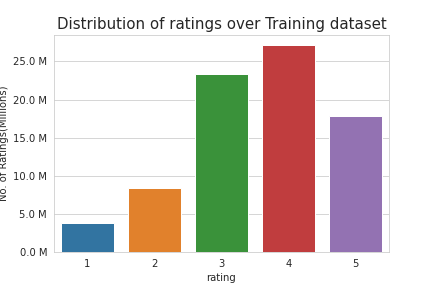

/home/deepanshu1/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/tmp/ipykernel_2120291/2679448952.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])


In [15]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

### Analysis on the Ratings given by user

In [16]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)


In [18]:
no_of_rated_movies_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

<IPython.core.display.Javascript object>


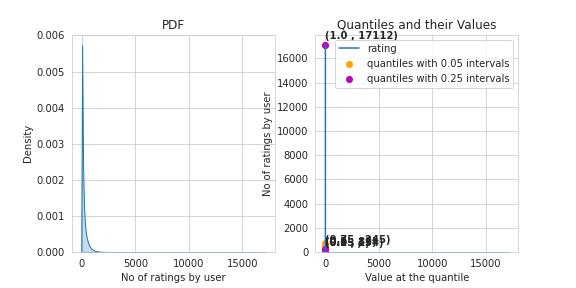

In [19]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [20]:
no_of_rated_movies_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

In [21]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [22]:
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

/tmp/ipykernel_2120291/2778937320.py:13: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)


In [23]:
quantiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

### Analysis of ratings of a movie given by a user

<IPython.core.display.Javascript object>


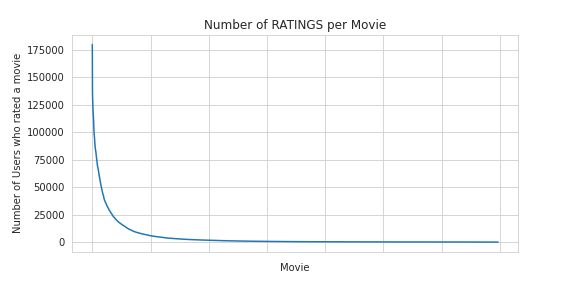

In [27]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('Number of RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('Number of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

## Creating sparse matrix from data frame

### Train data

In [4]:

if os.path.isfile('train_sparse_matrix.npz'):
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')

else: 

    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
 
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
   


<p><b>The Sparsity of Train Sparse Matrix</b></p>

In [40]:
users,movies = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(users*movies))) * 100) )

Sparsity Of Train matrix : 99.8292709259195 % 


### Test data

In [5]:

if os.path.isfile('test_sparse_matrix.npz'):
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
 
else: 

    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))

    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)

<p><b>The Sparsity of Test data Matrix</b></p>

In [30]:
users,movies = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(users*movies))) * 100) )

Sparsity Of Test matrix : 99.95731772988694 % 


<h3>3.3.7 Finding Global average of all movie ratings, Average rating per user, and Average rating per movie</h3>

In [7]:


def get_average_ratings(sparse_matrix, of_users):
    
    #this function will be used to compute avg rating for bith users and movies
    
    # ax = 1 - User axes,0 - Movie axes  
    ax = 1 if of_users else 0 

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    
    # no of ratings given by each user/ no of ratings given to a movie
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # no of users and movies
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    
    return average_ratings

<h4> 3.3.7.1 finding global average of all movie ratings </h4>

In [6]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.582890686321557}

<h4> 3.3.7.2 finding average rating per user</h4>

In [8]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.3781094527363185


<h4> 3.3.7.3 finding average rating per movie</h4>

In [9]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])


 AVerage rating of movie 15 : 3.3038461538461537


<h3> 3.3.8 Cold Start problem </h3>

<h4> 3.3.8.1 Cold Start problem with Users</h4>

In [10]:
total_users = len(np.unique(df.user))
users_in_train = len(train_averages['user'])
new_users = total_users - users_in_train

print('Total number of Users  :', total_users)
print('Number of Users in Train data :', users_in_train)
print("Number of Users that didn't appear in train data:", new_users)

Total number of Users  : 480189
Number of Users in Train data : 405041
Number of Users that didn't appear in train data: 75148


<h4> 3.3.8.2 Cold Start problem with Movies</h4>

In [11]:
total_movies = len(np.unique(df.movie))
movies_in_train = len(train_averages['movie'])
new_movies = total_movies - movies_in_train

print('Total number of Movies  :', total_movies)
print('Number of Users in Train data :', movies_in_train)
print("Number of Movies that didn't appear in train data:", new_movies)

Total number of Movies  : 17770
Number of Users in Train data : 17424
Number of Movies that didn't appear in train data: 346


<h2> 3.4 Computing Similarity matrices </h2>

<h3> 3.4.1 Computing User-User Similarity matrix </h3>

1. Calculating User User Similarity_Matrix is __not very easy__ Computing that will require high computing source and time.



-An alternative is to compute similar users for a particular user,  whenenver required (**ie., Run time**)
    - We maintain a binary Vector for users, which tells us whether we already computed or not..
    - ***If not*** : 
        - Compute top (let's just say, 1000) most similar users for this given user, and add this to our datastructure, so that we can just access it(similar users) without recomputing it again.
        - 
    - ***If It is already Computed***:
        - Just get it directly from our datastructure, which has that information.
        - In production time, We might have to recompute similarities, if it is computed a long time ago. Because user preferences changes over time. If we could maintain some kind of Timer, which when expires, we have to update it ( recompute it ). 
        - 
    - ***Which datastructure to use:***
        - It is purely implementation dependant. 
        - One simple method is to maintain a **Dictionary Of Dictionaries**.
            - 
            - **key    :** _userid_ 
            - __value__: _Again a dictionary_
                - __key__  : _Similar User_
                - __value__: _Similarity Value_

<h3> 3.4.2 Computing Movie-Movie Similarity matrix </h3>

In [12]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
else:
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")


In [13]:
m_m_sim_sparse.shape

(17771, 17771)

In [14]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [15]:

similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]


<h3> 3.4.3 Finding most similar movies using similarity matrix </h3>

In [18]:


movie_titles = pd.read_csv("movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head()

Tokenization took: 8.14 ms
Type conversion took: 11.64 ms
Parser memory cleanup took: 0.01 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


<p style='font-size:15px'><b>Similar Movies for 'Dinosaur Planet'</b></p>

In [19]:
mv_id = 1

print("Movie : ",movie_titles.loc[mv_id].values[1])

print("Ratings from users:", train_sparse_matrix[:,mv_id].getnnz())

print("Number of movies similar to this",m_m_sim_sparse[:,mv_id].getnnz())

Movie :  Dinosaur Planet
Ratings from users: 395
Number of movies similar to this 17297


In [20]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]

similarities[similar_indices]

#Sorting and reversing the array and ignoring the most similar movie(because most similar movie will be the queried movie only)
sim_indices = similarities.argsort()[::-1][1:] 

__Top 10 similar movies to Dinasour Planet__

In [27]:
movie_titles.loc[sim_indices[:10]]

,year_of_release,title
movie_id,,
694,2000.0,When Dinosaurs Roamed America
5302,2003.0,Chased by Dinosaurs: Three Walking with Dinosa...
1084,2001.0,Walking with Prehistoric Beasts
13586,2001.0,Allosaurus: A Walking with Dinosaurs Special
1173,1999.0,Walking with Dinosaurs
4181,2003.0,Walking with Cavemen
8800,2003.0,Prehistoric America: A Journey Through the Ice...
10656,2003.0,Before We Ruled the Earth: Mastering the Beasts
15648,2002.0,National Geographic: Dinosaur Hunters: Secrets...


 <h1> 4.  Machine Learning Models </h1>

As the dataset is very large and processing whole data will take too much time. Therfore below function is used to get subset of the dataset

In [31]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path):


    user_ids, movie_ids, ratings = sparse.find(sparse_matrix)
    unique_users = np.unique(user_ids)
    unique_movies = np.unique(movie_ids)


    np.random.seed(15)
    sample_users = np.random.choice(unique_users, no_users, replace=False)
    sample_movies = np.random.choice(unique_movies, no_movies, replace=False)
   
    mask = np.logical_and( np.isin(user_ids, sample_users),
                      np.isin(movie_ids, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (user_ids[mask], movie_ids[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    sparse.save_npz(path, sample_sparse_matrix)

    
    return sample_sparse_matrix

<h2> 4.1 Sampling Data </h2>

<h3>4.1.1 Build sample train data from the train data</h3>

In [21]:

if os.path.isfile('sample_train_sparse_matrix.npz'):
    
    sample_train_sparse_matrix = sparse.load_npz('sample_train_sparse_matrix.npz')
    
else: 
    
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,
                                             path ='sample_train_sparse_matrix.npz')


<h3>4.1.2 Build sample test data from the test data</h3>

In [22]:

path = "sample_test_sparse_matrix.npz"
if os.path.isfile('sample_test_sparse_matrix.npz'):

    sample_test_sparse_matrix = sparse.load_npz('sample_test_sparse_matrix.npz')

else:

    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = "sample_test_sparse_matrix.npz")


<h2>Finding global, users, movies averages in training data</h2>

In [25]:
sample_train_averages = dict()

<h3>4.2.1 Finding Global Average of all movie ratings</h3>

In [26]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.581679377504138}

<h3>4.2.2 Finding Average rating per User</h3>

In [27]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)


<h3>4.2.3 Finding Average rating per Movie</h3>

In [28]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)


<h2> Number of ratings </h2>

In [29]:
print("Number of ratings in Sampled train data",sample_train_sparse_matrix.count_nonzero())
print("Number of ratings in Sampled test data",sample_test_sparse_matrix.count_nonzero())


Number of ratings in Sampled train data 129286
Number of ratings in Sampled test data 7333


<h3> 4.3.1 Featurizing data for regression problem </h3>

<h4> 4.3.1.1 Featurizing train data </h4>

In [30]:

train_users, train_movies, train_ratings = sparse.find(sample_train_sparse_matrix)

In [38]:
sample_train_sparse_matrix.shape

(2649405, 17724)

In [34]:
len(train_users)

129286

In [36]:
train_ratings

array([4, 3, 5, ..., 3, 4, 4])

In [46]:

###This code will take too much time to run

if not os.path.isfile('reg_train.csv'):


    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(train_users, train_movies, train_ratings):
    
            #Calculating cosine similarity with every user of the given user
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            
            #Sorting according to the cosine similarity
            top_sim_users = user_sim.argsort()[::-1][1:] 
            
            #rating given by the top_similar_users to the given movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
           
            #Taking rating of only top 5 similar users
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
       
    
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] 
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
        
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        
            
            # we will make a list which will have user_id, movie_id, global avg of data, 
            #5 most similar users , 5 most similar movies, user avg, movie avg and finally actual rating of the movie
            entry_list = list()
            entry_list.append(user)
            
            entry_list.append(movie)
            
            #global avg of the data
            entry_list.append(sample_train_averages['global']) 
            #top 5 simiilar users rating to the movie
            entry_list.extend(top_sim_users_ratings)
            #top 5 similar movies ratings
            entry_list.extend(top_sim_movies_ratings)
            # Avg user rating
            entry_list.append(sample_train_averages['user'][user])
            # Avg movie rating
            entry_list.append(sample_train_averages['movie'][movie])
            # Actual rating
            entry_list.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, entry_list)))
            reg_data_file.write('\n')        
            



In [4]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'Global_avg', 'U1', 'U2', 'U3', 'U4', 'U5','M1', 'M2', 'M3', 'M4', 'M5', 'User_Avg', 'Movie_Avg', 'rating'], header=None)
reg_train.head()

,user,movie,Global_avg,U1,U2,U3,U4,U5,M1,M2,M3,M4,M5,User_Avg,Movie_Avg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


-----------------------

- __Global_avg__ : Average rating of all the data 

- __U1,..,U5__:  Top 5 similar users who rated that movie
    
- __M1,...,M5__: Top 5 similar movies rated by the user

- __User_Avg__ : User's Average rating

- __Movie_Avg__ : Average rating of this movie

- __rating__ : Actual Rating of this movie by this user.

-----------------------

<h4> Featurizing test data </h4>

In [44]:
test_users, test_movies, test_ratings = sparse.find(sample_test_sparse_matrix)

In [45]:


if not os.path.isfile('reg_test.csv'):


    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('sample/small/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(test_users, test_movies, test_ratings):
            

       
            try:
                      
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:]
                
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                

            except (IndexError, KeyError):
                # new User or new Movie or there are no ratings for given user for top similar movies.
                
                #Cold Start Problem 
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
            except:
                # Any other error
                raise


            try:
                  
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:]
                
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
           
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
              
            except (IndexError, KeyError):
                
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
               
            except :
                raise

            entry_list = list()
         
            entry_list.append(user)
            entry_list.append(movie)
            entry_list.append(sample_train_averages['global'])
            
            entry_list.extend(top_sim_users_ratings)
           
            entry_list.extend(top_sim_movies_ratings)
            
            try:
                entry_list.append(sample_train_averages['user'][user])
            except KeyError:
                entry_list.append(sample_train_averages['global'])
            except:
                raise
            
            try:
                entry_list.append(sample_train_averages['movie'][movie])
            except KeyError:
                entry_list.append(sample_train_averages['global'])
            except:
                raise
        
            entry_list.append(rating)
          
            count = count + 1

        
            reg_data_file.write(','.join(map(str, entry_list)))
        
            reg_data_file.write('\n')        
     


__Reading from the file to make a test dataframe __

In [5]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'Global_avg', 'U1', 'U2', 'U3', 'U4', 'U5','M1', 'M2', 'M3', 'M4', 'M5', 'User_Avg', 'Movie_Avg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,Global_avg,U1,U2,U3,U4,U5,M1,M2,M3,M4,M5,User_Avg,Movie_Avg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


<h3> 4.3.2 Transforming data for Surprise models</h3>

In [4]:
pip install numpy==1.20.0

     |████████████████████████████████| 15.4 MB 42 kB/s eta 0:00:01
ERROR: tensorflow 2.6.0 has requirement numpy~=1.19.2, but you'll have numpy 1.20.0 which is incompatible.
ERROR: tensorflow-gpu 2.6.0 has requirement numpy~=1.19.2, but you'll have numpy 1.20.0 which is incompatible.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
Note: you may need to restart the kernel to use updated packages.


In [1]:
from surprise import Reader, Dataset

<h4> 4.3.2.1 Transforming train data </h4>

For using surprise library, we have to give data in the specific format.
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

In [6]:
#to specify how to read the dataframe.

reader = Reader(rating_scale=(1,5))

# create the traindata
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata
#It is of dataset format from surprise library.
trainset = train_data.build_full_trainset() 

<h4> 4.3.2.2 Transforming test data </h4>

- Testset is just a list of (user, movie, rating) tuples. (Order in the tuple is impotant) 

In [7]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

<h2> 4.4 Applying Machine Learning models </h2>

-  Global dictionary that stores rmse and mape for all the models....


In [20]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

 > __Utility functions for running regression models__

In [14]:

def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

In [15]:



def run_xgboost(algo,  x_train, y_train, x_test, y_test):

    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    algo.fit(x_train, y_train, eval_metric = 'rmse')


    #prediction using model
    y_train_pred = algo.predict(x_train)
    
    # rmse and mape of train data
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results 
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
   

    # Test data
 
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}

    print('TEST DATA')
    print('RMSE : ', rmse_test)
    print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

> __Utility functions for Surprise modes__

In [16]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)


def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

In [17]:


def run_surprise(algo, trainset, testset): 

  
    train = dict()
    test = dict()
    

    algo.fit(trainset)

    # train prediction
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
  
    


    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    

 
    #Test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)

    
  
    print('Test Data')
    print('-'*15)
    print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))

    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    

    return train, test

<h3> 4.4.1 XGBoost with initial 13 features </h3>

In [18]:
import xgboost as xgb

[04:07:36] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


TEST DATA
RMSE :  1.1016770831525975
MAPE :  33.379025364595144


<IPython.core.display.Javascript object>


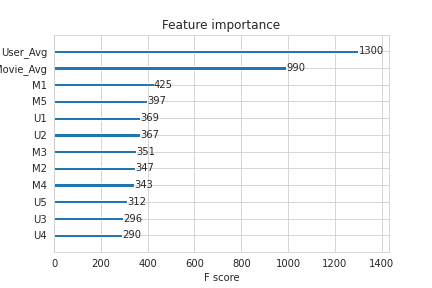

In [21]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

<h3> 4.4.2 Suprise BaselineModel </h3>
    


In [23]:
from surprise import BaselineOnly 

In [25]:

bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Estimating biases using sgd...
Test Data
---------------
RMSE : 1.0730330260516174

MAPE : 35.04995544572911



<h3> 4.4.3 XGBoost with initial 13 features + Surprise Baseline predictor </h3>

__Updating Train Data__

In [26]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,Global_avg,U1,U2,U3,U4,U5,M1,M2,M3,M4,M5,User_Avg,Movie_Avg,rating,bslpr
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403


__Updating Test Data__

In [27]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,Global_avg,U1,U2,U3,U4,U5,M1,M2,M3,M4,M5,User_Avg,Movie_Avg,rating,bslpr
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679


[04:09:50] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


TEST DATA
RMSE :  1.1000463052939882
MAPE :  33.440093738533456


<IPython.core.display.Javascript object>


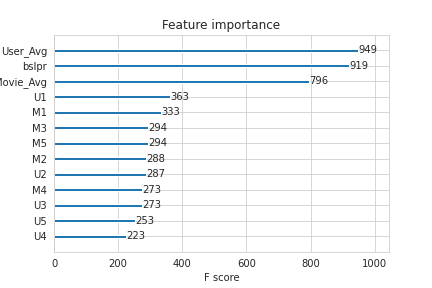

In [28]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()


<h3> 4.4.4 Surprise KNNBaseline predictor </h3>

In [29]:
from surprise import KNNBaseline

  <h4> 4.4.4.1 Surprise KNNBaseline with user user similarities</h4>

In [31]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Test Data
---------------
RMSE : 1.0726493739667242

MAPE : 35.02094499698424



<h4> 4.4.4.2 Surprise KNNBaseline with movie movie similarities</h4>

In [33]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Test Data
---------------
RMSE : 1.072758832653683

MAPE : 35.02269653015042



<h3> 4.4.5 XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor </h3>

In [34]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head()

,user,movie,Global_avg,U1,U2,U3,U4,U5,M1,M2,M3,M4,M5,User_Avg,Movie_Avg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982,3.930020,3.867958
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403,3.177330,3.076302
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5,3.323708,3.572503,3.401177
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5,3.378411,3.255531,3.086772
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5,3.691637,3.299517,3.249660


__Preparing Test data  __

In [35]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head()

,user,movie,Global_avg,U1,U2,U3,U4,U5,M1,M2,M3,M4,M5,User_Avg,Movie_Avg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3,3.581679,3.581679,3.581679
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679
4,28572,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,1,3.581679,3.581679,3.581679


TEST DATA
RMSE :  1.0887576141058135
MAPE :  33.83328394123822


<IPython.core.display.Javascript object>


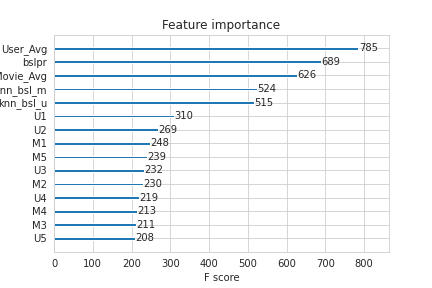

In [36]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

<h3> 4.4.6 Matrix Factorization Techniques </h3>

<h4> 4.4.6.1 SVD Matrix Factorization User Movie intractions </h4>

In [37]:
from surprise import SVD

In [38]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Test Data
---------------
RMSE : 1.0726046873826458

MAPE : 35.01953535988152



  <h4> 4.4.6.2 SVD Matrix Factorization with implicit feedback from user ( user rated movies ) </h4>

In [39]:
from surprise import SVDpp

In [40]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Test Data
---------------
RMSE : 1.0728491944183447

MAPE : 35.03817913919887



<h3> 4.4.7 XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

__Preparing Train data__

In [41]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,Global_avg,U1,U2,U3,U4,U5,M1,M2,...,M4,M5,User_Avg,Movie_Avg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,...,3.0,1.0,3.370370,4.092437,4,3.898982,3.93002,3.867958,4.303764,3.621664
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,...,3.0,5.0,3.555556,4.092437,3,3.371403,3.17733,3.076302,3.278967,3.538247


__Preparing Test data  __

In [42]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,Global_avg,U1,U2,U3,U4,U5,M1,M2,...,M4,M5,User_Avg,Movie_Avg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679,3.581679,3.581679


TEST DATA
RMSE :  1.0858226171103014
MAPE :  33.98041189391535


<IPython.core.display.Javascript object>


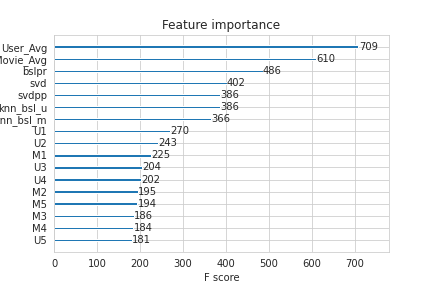

In [43]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

<h3> 4.4.8 XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

TEST DATA
RMSE :  1.0758207642755726
MAPE :  34.98203479380461


<IPython.core.display.Javascript object>


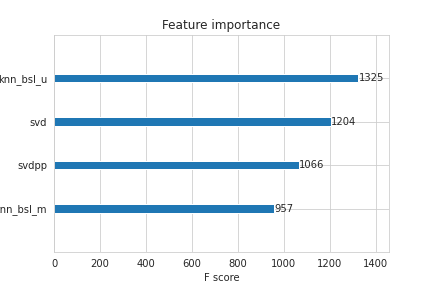

In [44]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

<h2> 4.5 Comparision between all models </h2>

In [45]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('small_sample_results.csv')
models = pd.read_csv('small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

svd               1.0726046873826458
knn_bsl_u         1.0726493739667242
knn_bsl_m          1.072758832653683
svdpp             1.0728491944183447
bsl_algo          1.0730330260516174
xgb_all_models    1.0758207642755726
xgb_final         1.0858226171103014
xgb_knn_bsl       1.0887576141058135
xgb_bsl           1.1000463052939882
first_algo        1.1016770831525975
Name: rmse, dtype: object